# Some coding stuff that came up while trying to use apply_ufunc to significance testing on a lat-lon grid

### Jonah Shaw, 09/22/2021

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### General example is not working due to memory issues?...

### Use a local file instead (CERES ASR)

I am using files from Brian Medeiros (most recent, somehow processed)

In [9]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [15]:
ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)

ceres_asr_tsel = ceres_asr.sel(time=slice('2001-01-01','2020-12-31'))

ceres_asr.close()

Select one month from the CERES data to use as an example

In [23]:
monthlys = ceres_asr_tsel['ASR'].groupby('time.month')#.mean('time')[0]#.groupby('time.year').mean('year')


In [40]:
for i,ex_data in monthlys:
    break

ex_timeseries = ex_data.groupby('time.year').mean('time')

### Define different approaches

#### Jonah Approach

Gets all 5 values from scipy.stats.linregress, takes ~13.3s in this scenario

In [43]:
def linregress1d_np(data, times):
#     print(f"data: {data.shape} | x: {times.shape}") # different formatting syntax
    return stats.linregress(times, data)

# %%timeit

# Use unchunked data that hasn't been put into an array
regressed_jonahtest = xr.apply_ufunc(
        linregress1d_np,  # first the function
        ex_timeseries,  # now arguments in the order expected by 'regress1_np'
        ex_timeseries.year,
        input_core_dims=[["year"], ["year"],],
        output_core_dims= [[] for _ in range(5)],
        exclude_dims=set(("year",)),
        vectorize=True,
        dask="parallelized",
        output_dtypes=[ex_timeseries.dtype for _ in range(5)], # one per output
    #     output_sizes={"parameter": 5},
    )

#### Riley Brady Approach

In [47]:
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

# return a new DataArray
regressed_rileytest = xr.apply_ufunc(new_linregress, 
                       ex_timeseries, 
                       ex_timeseries.year,
                       input_core_dims=[['year'], ['year']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},
                      )

#### Single variable dasked approach

In [102]:
def slope_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope

# %%timeit

regressed_test_slope = xr.apply_ufunc(
    slope_linregress,  # first the function
    ex_timeseries.chunk({"lat": 1, "lon": 1}),  # now arguments in the order expected by 'regress1_np'
    ex_timeseries.year,
    input_core_dims=[["year"], ["year"],],
#     output_core_dims= [[] for _ in range(5)],
    output_core_dims= [[]],
    exclude_dims=set(("year",)),
    vectorize=True,
    dask="parallelized",
#     output_dtypes=[ex_timeseries.dtype for _ in range(5)], # one per output
    output_dtypes=[ex_timeseries.dtype], # one per output
)

# interped["lat"] = newlat  # need to add this manually
# xr.testing.assert_allclose(expected.isel(time=0, lon=0), interped)


Since this is done with a chunked array, the operations are lazy and are only computed when needed. It also is giving the same wrong answers as the Brady approach.

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm


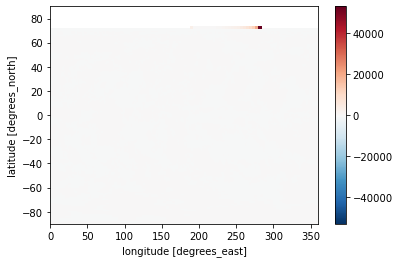

In [104]:
regressed_test_slope.plot()

#### Limited Real Answers

Just slope and intercept

In [45]:
regressed_polyfit = ex_timeseries.polyfit(dim='year',deg=1)

#### Plot for comparison (for slope and intercept)

Text(0.5, 1.0, 'Riley slope')

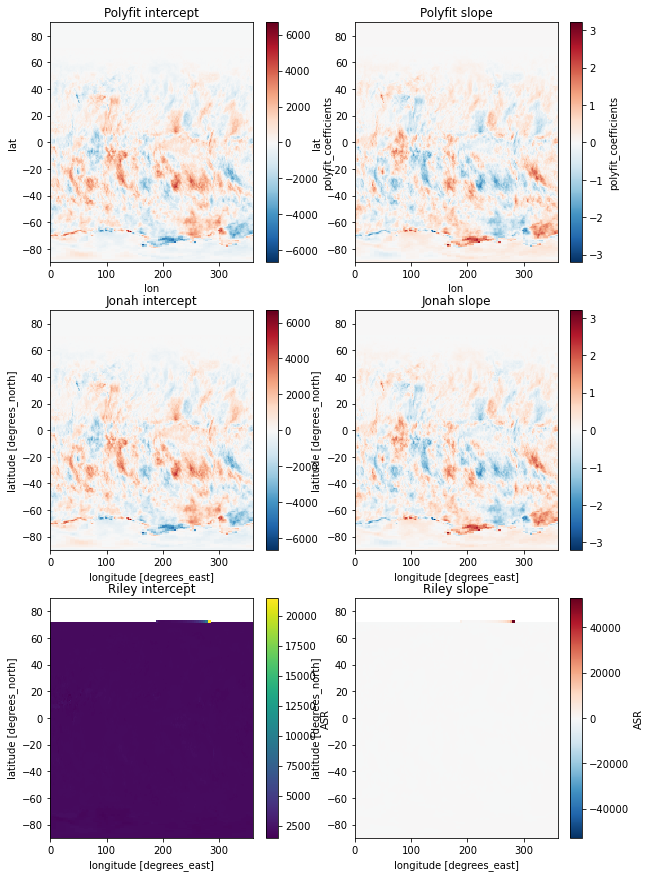

In [48]:
slope_fig,slope_axes = plt.subplots(nrows=3,ncols=2,figsize=(10,15))

axes_col1 = slope_axes[:,0]
axes_col2 = slope_axes[:,1]

regressed_polyfit.sel(degree=0)['polyfit_coefficients'].plot(ax=axes_col1[0])
axes_col1[0].set_title('Polyfit intercept')

regressed_polyfit.sel(degree=1)['polyfit_coefficients'].plot(ax=axes_col2[0])
axes_col2[0].set_title('Polyfit slope')

regressed_jonahtest[1].plot(ax=axes_col1[1])
axes_col1[1].set_title('Jonah intercept')

regressed_jonahtest[0].plot(ax=axes_col2[1])
axes_col2[1].set_title('Jonah slope')

regressed_rileytest.isel(parameter=1).plot(ax=axes_col1[2])
axes_col1[2].set_title('Riley intercept')

regressed_rileytest.isel(parameter=0).plot(ax=axes_col2[2])
axes_col2[2].set_title('Riley slope')


Not sure why Riley's method is producing weird values here. It agree with my method for the pvalues and standard deviations, so it must have to do with the functions themselves.

### Numba and guvectorize stuff (not working)

In [132]:
from numba import float64, guvectorize

Example from the apply_ufunc tutorial:
https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html

In [131]:
@guvectorize("(float64[:], float64[:], float64[:], float64[:])", "(n), (n), (m) -> (m)") # first line is all of the input and then describing which are passed versus just operated on
def interp1d_np_gufunc(data, x, xi, out):
    # numba doesn't really like this.
    # seem to support fstrings so do it the old way
    print(
        "data: " + str(data.shape) + " | x:" + str(x.shape) + " | xi: " + str(xi.shape)
    )
    out[:] = np.interp(xi, x, data)
    # gufuncs don't return data
    # instead you assign to a the last arg
    # return np.interp(xi, x, data)

<ipython-input-131-799edcdb7012>:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "interp1d_np_gufunc" failed type inference due to: No implementation of function Function(<class 'str'>) found for signature:
 
 >>> str(UniTuple(int64 x 1))
 
There are 4 candidate implementations:
    - Of which 4 did not match due to:
    Overload of function 'str': File: <numerous>: Line N/A.
      With argument(s): '(UniTuple(int64 x 1))':
     No match.

During: resolving callee type: Function(<class 'str'>)
During: typing of call at <ipython-input-131-799edcdb7012> (9)


File "<ipython-input-131-799edcdb7012>", line 9:
def interp1d_np_gufunc(data, x, xi, out):
    <source elided>
    print(
        "data: " + str(data.shape) + " | x:" + str(x.shape) + " | xi: " + str(xi.shape)
        ^

  @guvectorize("(float64[:], float64[:], float64[:], float64[:])", "(n), (n), (m) -> (m)")
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-

My attempt at replication (not going to be efficient because of linregress issues.

In [151]:
# Write the regression function in a way that numba can parallelize it. 
# Apparently the scipy lingress function is giving numba issues with this error:
# Compilation is falling back to object mode WITHOUT looplifting enabled because Function "regress1d_np_gufunc" failed type inference due to: 
# Unknown attribute 'linregress' of type Module(<module 'scipy.stats' from '/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/scipy/stats/__init__.py'>)

@guvectorize("(float64[:], float64[:], float64[:], float64[:])", "(n), (n), (m) -> (m)") # n is the number of timesteps and m is always 5
def regress1d_np_gufunc(data, times, dum, out):
    '''
    Need to pass a dummy array of size 5 so that it doesn't get mad, silly. 
    https://github.com/numba/numba/issues/2797
    '''
    # numba doesn't really like this.
    # seem to support fstrings so do it the old way
#     print(
#         "data: " + str(data.shape) + " | x:" + str(times.shape)
#     )
    out[:] = stats.linregress(times, data) # numba doesn't like linregress either

<ipython-input-151-bb5be6ee80c2>:6: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "regress1d_np_gufunc" failed type inference due to: Unknown attribute 'linregress' of type Module(<module 'scipy.stats' from '/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/scipy/stats/__init__.py'>)

File "<ipython-input-151-bb5be6ee80c2>", line 17:
def regress1d_np_gufunc(data, times, dum, out):
    <source elided>
#     )
    out[:] = stats.linregress(times, data) # numba doesn't like linregress either
    ^

During: typing of get attribute at <ipython-input-151-bb5be6ee80c2> (17)

File "<ipython-input-151-bb5be6ee80c2>", line 17:
def regress1d_np_gufunc(data, times, dum, out):
    <source elided>
#     )
    out[:] = stats.linregress(times, data) # numba doesn't like linregress either
    ^

  @guvectorize("(float64[:], float64[:], float64[:], float64[:])", "(n), (n), (m) -> (m)") # n is the number of timesteps and m 

### Moving on to calculating significant trends from this data.

In [49]:
slopes = regressed_jonahtest[0]
intercepts = regressed_jonahtest[1]
rvalues = regressed_jonahtest[2]
pvalues = regressed_jonahtest[3]
stderrs = regressed_jonahtest[4]

In [50]:
N = len(ex_timeseries.year)
dof=N-2

tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
t=rvalues*np.sqrt(N-2)/np.sqrt((1-rvalues*rvalues))

statsig_percent=(1-pvalues)*100

This is December, so we don't see anything in the Arctic. There seem to be some significant trends in Antarctica, but most things are scattered.

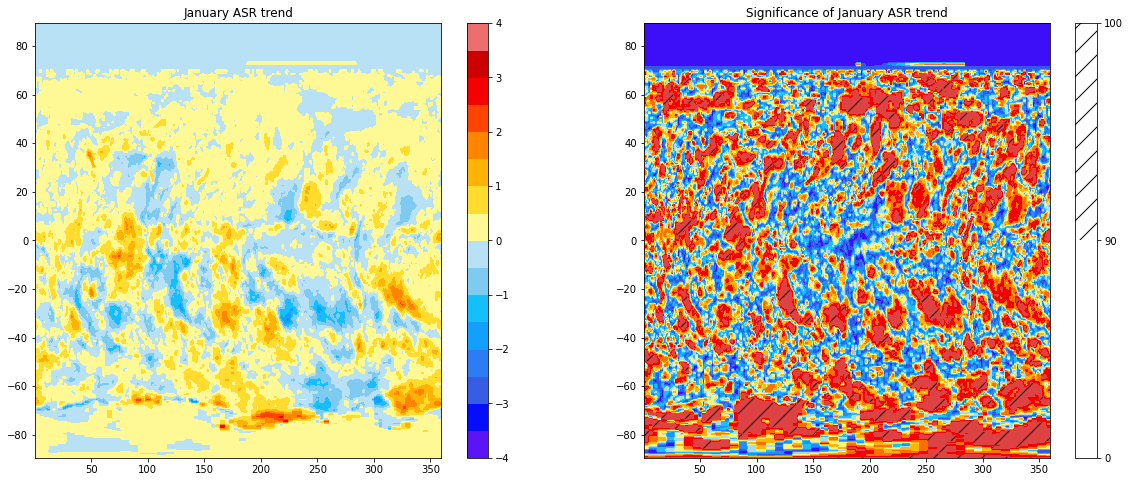

In [95]:
fig,axs = plt.subplots(1,2,figsize=(20,8))

im = axs[0].contourf(slopes['lon'],slopes['lat'],slopes,cmap=cmaps.ncl_default,levels=np.arange(-4,4.01,0.5))
axs[0].set_title('January ASR trend')

im2 = axs[1].contourf(statsig_percent['lon'],statsig_percent['lat'],statsig_percent,cmap=cmaps.ncl_default,levels=np.arange(0,100.1,10))
stip = axs[1].contourf(statsig_percent['lon'],statsig_percent['lat'],statsig_percent,3, colors='none',levels=[0,90,100],
              hatches=[None,'/'],
              extend='neither')
axs[1].set_title('Significance of January ASR trend')

plt.colorbar(im,ax=axs[0])
plt.colorbar(stip,ax=axs[1])

#### Plot trends and hatch areas where they are statistically significant at 2 sigma

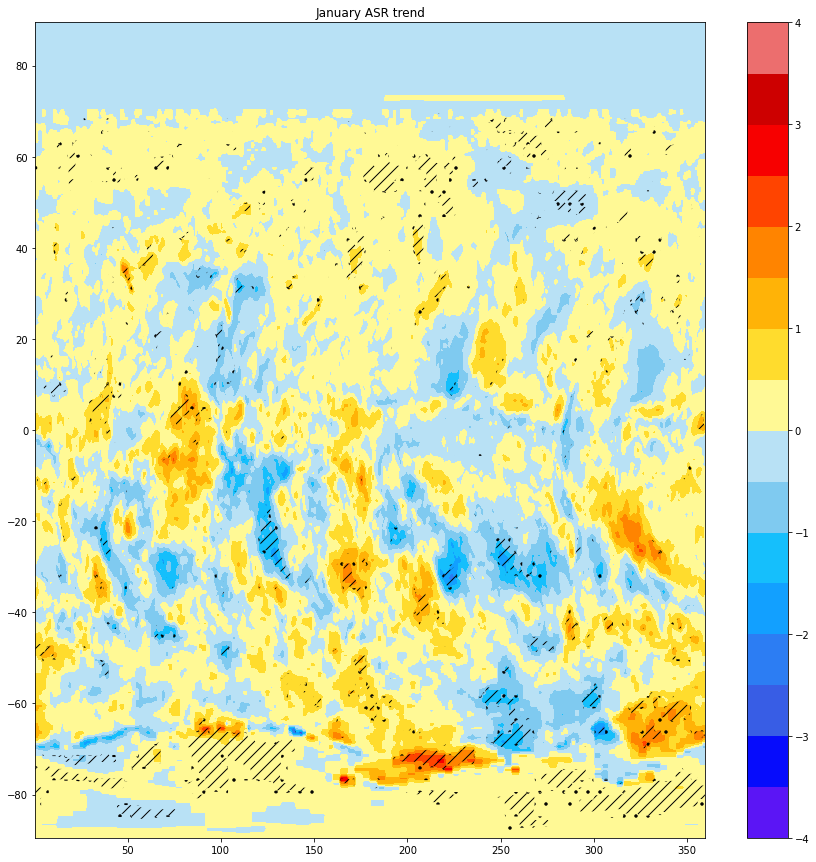

In [101]:
fig,axs = plt.subplots(1,1,figsize=(15,15))

im = axs.contourf(slopes['lon'],slopes['lat'],slopes,cmap=cmaps.ncl_default,levels=np.arange(-4,4.01,0.5))
axs.set_title('January ASR trend')

# im2 = axs[1].contourf(statsig_percent['lon'],statsig_percent['lat'],statsig_percent,cmap=cmaps.ncl_default,levels=np.arange(0,100.1,10))
stip = axs.contourf(statsig_percent['lon'],statsig_percent['lat'],statsig_percent,3, colors='none',levels=[0,90,95,100],
              hatches=[None,'.','//'],
              extend='neither')
# axs[1].set_title('Significance of January ASR trend')

plt.colorbar(im,ax=axs)
# plt.colorbar(stip,ax=axs[1])